<a href="https://colab.research.google.com/github/MohemedAmine/Customer_Segmentation/blob/main/Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial to play with it yourself.


In [34]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="PAWrAGQr8BzsvbsteKIm")  # remplace par ta vraie clé API si nécessaire
project = rf.workspace("brad-dwyer").project("pothole-voxrl")
version = project.version(1)
dataset = version.download("coco")  # télécharge en format YOLOv8

print(dataset.location)


loading Roboflow workspace...
loading Roboflow project...
/content/Pothole-1


# Install detectron2

In [2]:
!pip install torch==2.7.0 torchvision==0.22.0 --index-url https://download.pytorch.org/whl/cu126
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu126/torch2.7/index.html



Looking in indexes: https://download.pytorch.org/whl/cu126
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu126/torch2.7/index.html


In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

[05/21 16:03:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/21 16:03:52 d2.engine.train_loop]: Starting training from iteration 0
[05/21 16:04:00 d2.utils.events]:  eta: 0:06:33  iter: 19  total_loss: 1.222  loss_cls: 0.6964  loss_box_reg: 0.3261  loss_rpn_cls: 0.181  loss_rpn_loc: 0.0273    time: 0.3956  last_time: 0.3954  data_time: 0.0196  last_data_time: 0.0223   lr: 4.9953e-06  max_mem: 6087M
[05/21 16:04:08 d2.utils.events]:  eta: 0:06:25  iter: 39  total_loss: 1.178  loss_cls: 0.6503  loss_box_reg: 0.3834  loss_rpn_cls: 0.12  loss_rpn_loc: 0.01609    time: 0.3934  last_time: 0.3227  data_time: 0.0111  last_data_time: 0.0167   lr: 9.9902e-06  max_mem: 6087M
[05/21 16:04:16 d2.utils.events]:  eta: 0:06:17  iter: 59  total_loss: 1.212  loss_cls: 0.5357  loss_box_reg: 0.5336  loss_rpn_cls: 0.1367  loss_rpn_loc: 0.01868    time: 0.3973  last_time: 0.3391  data_time: 0.0125  last_data_time: 0.0197   lr: 1.4985e-05  max_mem: 6087M
[05/21 16:04:24 d2.utils.events]:  eta: 0:06:06  iter: 79  total_loss: 1.304  loss_cls: 0.4845  loss_box_reg: 0

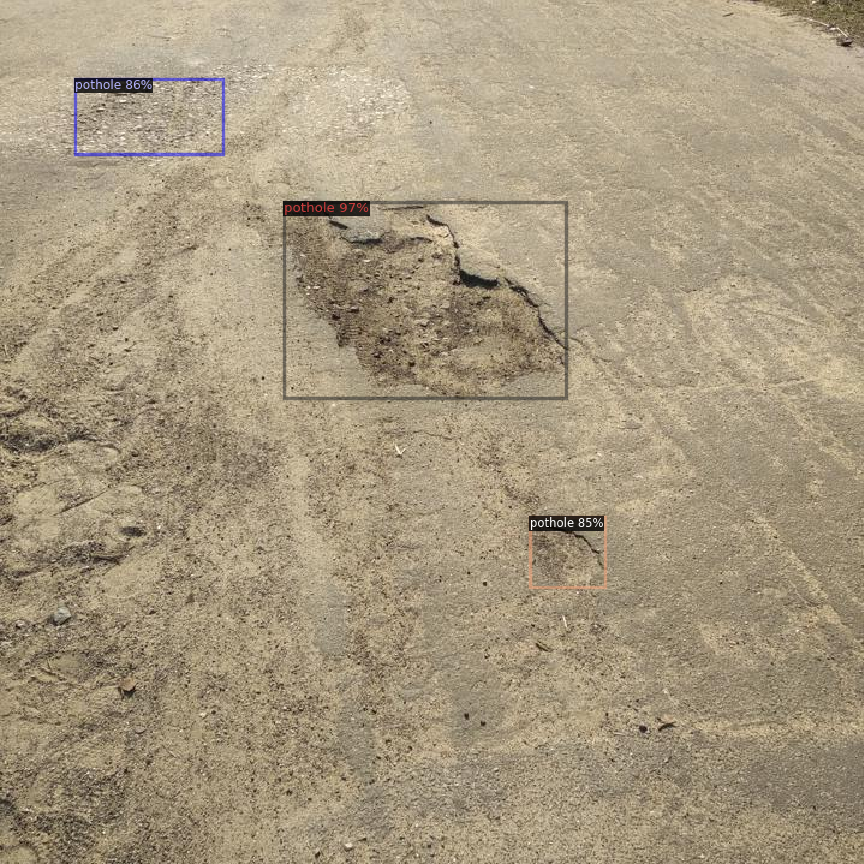

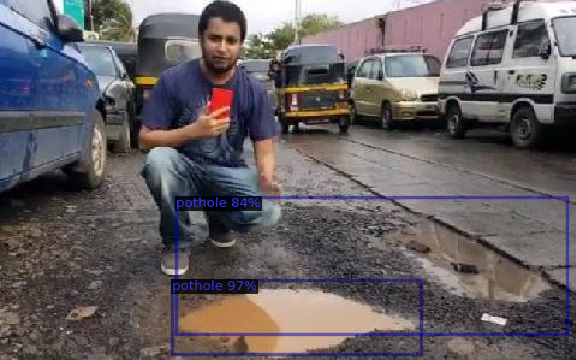

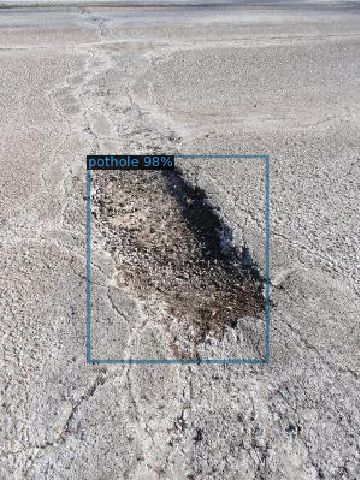

In [37]:
import os
import cv2
import random
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from google.colab.patches import cv2_imshow  # Pour Colab uniquement

# Initialisation
setup_logger()

# Nettoyage
for d in ["pothole_train", "pothole_val"]:
    if d in DatasetCatalog.list():
        DatasetCatalog.remove(d)
    if d in MetadataCatalog.list():
        MetadataCatalog.remove(d)

# Chemins
dataset_dir = "/content/Pothole-1"
train_json = os.path.join(dataset_dir, "train", "_annotations.coco.json")
val_json = os.path.join(dataset_dir, "valid", "_annotations.coco.json")
train_img_dir = os.path.join(dataset_dir, "train")
val_img_dir = os.path.join(dataset_dir, "valid")

assert os.path.exists(train_json), f"{train_json} introuvable"
assert os.path.exists(val_json), f"{val_json} introuvable"

# ⚠️ Utiliser uniquement la catégorie avec id=1 ("pothole") pour l'entraînement
def filter_coco_by_category(json_path, allowed_ids=[1]):
    import json
    with open(json_path, 'r') as f:
        data = json.load(f)

    data['annotations'] = [a for a in data['annotations'] if a['category_id'] in allowed_ids]
    data['categories'] = [c for c in data['categories'] if c['id'] in allowed_ids]

    filtered_path = json_path.replace(".json", "_filtered.json")
    with open(filtered_path, 'w') as f:
        json.dump(data, f)

    return filtered_path

train_json_filtered = filter_coco_by_category(train_json)
val_json_filtered = filter_coco_by_category(val_json)

# Enregistrement
register_coco_instances("pothole_train", {}, train_json_filtered, train_img_dir)
register_coco_instances("pothole_val", {}, val_json_filtered, val_img_dir)

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pothole_train",)
cfg.DATASETS.TEST = ("pothole_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Une seule classe : pothole
cfg.OUTPUT_DIR = "./output_pothole"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Entraînement
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Évaluation
evaluator = COCOEvaluator("pothole_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "pothole_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

# Prédiction
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

# Visualisation
dataset_dicts = DatasetCatalog.get("pothole_val")
metadata = MetadataCatalog.get("pothole_train")

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


In [42]:
import os
import cv2
import random
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# === 1. Enregistrer le dataset de test (format COCO) ===
test_images_path = "/content/Pothole-1/test"
test_annotations_path = "/content/Pothole-1/test/_annotations.coco.json"

register_coco_instances("pothole_test", {}, test_annotations_path, test_images_path)

# === 2. Configuration du modèle ===
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # config de base
cfg.MODEL.WEIGHTS = "/content/output_pothole/model_final.pth"  # Chemin vers ton modèle entraîné
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Seuil de confiance
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Ajuste selon ton dataset (1 si seulement "pothole")
cfg.MODEL.DEVICE = "cuda"  # ou "cpu" selon l’environnement

predictor = DefaultPredictor(cfg)

# === 3. Charger le dataset de test ===
dataset_dicts = DatasetCatalog.get("pothole_test")
metadata = MetadataCatalog.get("pothole_test")

# === 4. Faire des prédictions et afficher les résultats ===
output_dir = "/content/predictions"
os.makedirs(output_dir, exist_ok=True)

for i, d in enumerate(dataset_dicts):
    img_path = d["file_name"]
    img = cv2.imread(img_path)
    outputs = predictor(img)

    # Visualisation
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Sauvegarde de l'image avec prédiction
    output_path = os.path.join(output_dir, f"pred_{i}.jpg")
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
    print(f"[{i+1}/{len(dataset_dicts)}] Sauvé: {output_path}")

print("✅ Test terminé avec succès.")



[05/21 16:16:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output_pothole/model_final.pth ...
WARNING [05/21 16:16:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 16:16:51 d2.data.datasets.coco]: Loaded 67 images in COCO format from /content/Pothole-1/test/_annotations.coco.json
[1/67] Sauvé: /content/predictions/pred_0.jpg
[2/67] Sauvé: /content/predictions/pred_1.jpg
[3/67] Sauvé: /content/predictions/pred_2.jpg
[4/67] Sauvé: /content/predictions/pred_3.jpg
[5/67] Sauvé: /content/predictions/pred_4.jpg
[6/67] Sauvé: /content/predictions/pred_5.jpg
[7/67] Sauvé: /content/predictions/pred_6.jpg
[8/67] Sauvé: /content/predictions/pred_7.jpg
[9/67] Sauvé: /content/predictions/pred_8.jpg
[10/67] Sauvé: /content/predictions/pred_9.jpg
[11/67] Sauvé: /content/predictions/pred_10.jpg
[12/67] Sauvé: /content/predictions/pred_11.jpg
[13/67] Sauvé: /content/predictions/pred_12.jpg